In [119]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    

In [120]:
import cv2

from torch.utils.data import DataLoader

from MagicPoint.dataset.tum_dataset import TUMDataset, collate as tum_collate
from MagicPoint.dataset.art_dataset import ArtificialDataset, collate as art_collate

from MagicPoint.model.magic_point import MagicPoint

from common.utils import *
from common.model_utils import filter_probabilities, homography_adaptation

%load_ext autoreload
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
config = load_config('../configs/tum_config_notebooks.yaml')

tum_data_config = dict(config['data'])
art_data_config = dict(config['data'])

tum_data_config['name'] = tum_data_config['name'][0]
art_data_config['name'] = art_data_config['name'][1]

model_config = config['model']
experiment_config = config['experiment']

set_seed(experiment_config['seed'])


In [56]:

tum_dataset = TUMDataset(tum_data_config)
tum_dataset_loader = DataLoader(tum_dataset, model_config['batch_size'], collate_fn=tum_collate)


In [57]:
art_dataset = ArtificialDataset(TEST, art_data_config)
art_dataset_loader = DataLoader(art_dataset, model_config['batch_size'], collate_fn=art_collate, 
                                shuffle=True)


In [126]:

device = torch.device('cpu')

model = MagicPoint(model_config).to(device)

if experiment_config['load_checkpoints']:
    checkpoint_path = get_checkpoint_path(experiment_config, model_config,
                                          experiment_config['load_checkpoint_iter'])
    if checkpoint_path.exists():
        epoch, model_sd, optimizer_sd = load_checkpoint(checkpoint_path, map_location=lambda storage, loc: storage)
        model.load_state_dict(model_sd)
    

In [127]:
def test_dataset(rows, dataset_loader):
    count = 0
    with torch.no_grad():
        for item in dataset_loader:
            frames = []
            titles = []
            
            image = to255scale(item[IMAGE][0].detach().numpy()).transpose((1, 2, 0))
    
            y_pred = model(item[IMAGE].to(device))
            probs = filter_probabilities(y_pred['probs'], model_config)
    
            frame_keypoints = [cv2.KeyPoint(c[1], c[0], 1) for c in np.stack(np.where(probs)).T]
            
            frames.append(cv2.drawKeypoints(image, frame_keypoints, None, color=(0, 255, 0)))
            titles.append("{};{}".format(item[IMAGE][0].shape, probs.shape))
            
            y_pred = model(item[IMAGE].to(device))
            probs = homography_adaptation(item[IMAGE].to(device), y_pred['probs'], model, model_config)
    
            frame_keypoints = [cv2.KeyPoint(c[1], c[0], 1) for c in np.stack(np.where(probs)).T]
            
            frames.append(cv2.drawKeypoints(image, frame_keypoints, None, color=(0, 255, 0)))
            titles.append("{};{}".format(item[IMAGE][0].shape, probs.shape))
    
            plot_images(frames, titles)
    
            count += 1
            if count == rows:
                break
     

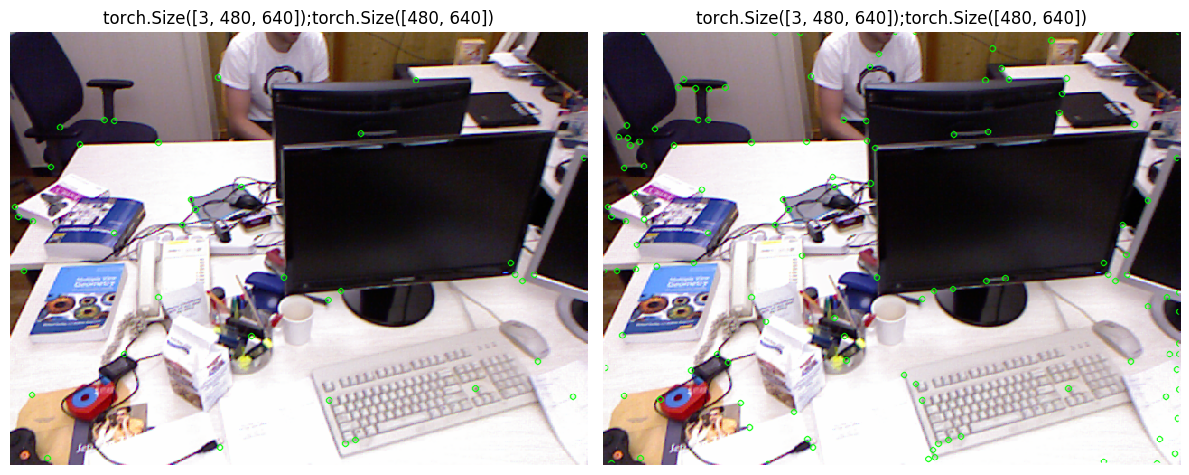

In [128]:
test_dataset(1, tum_dataset_loader)


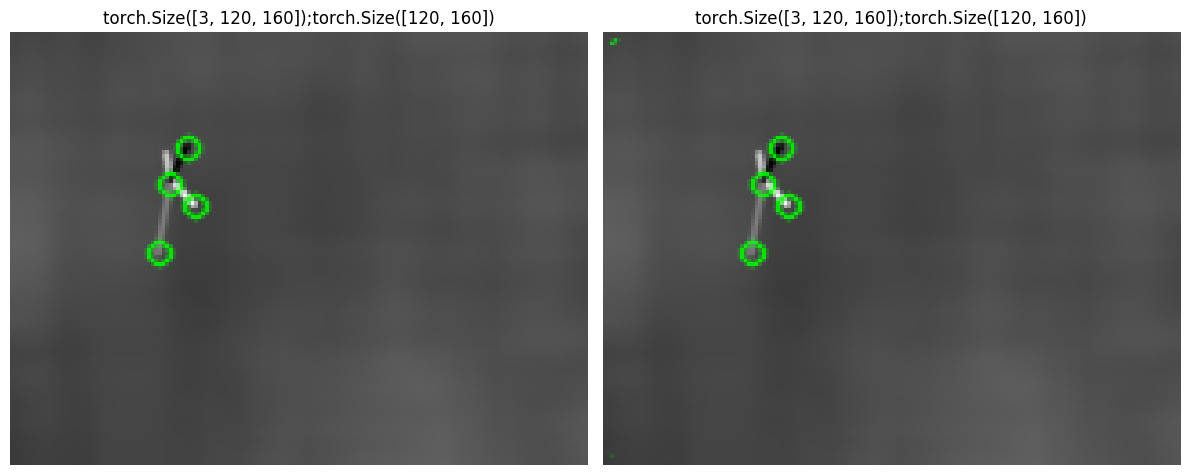

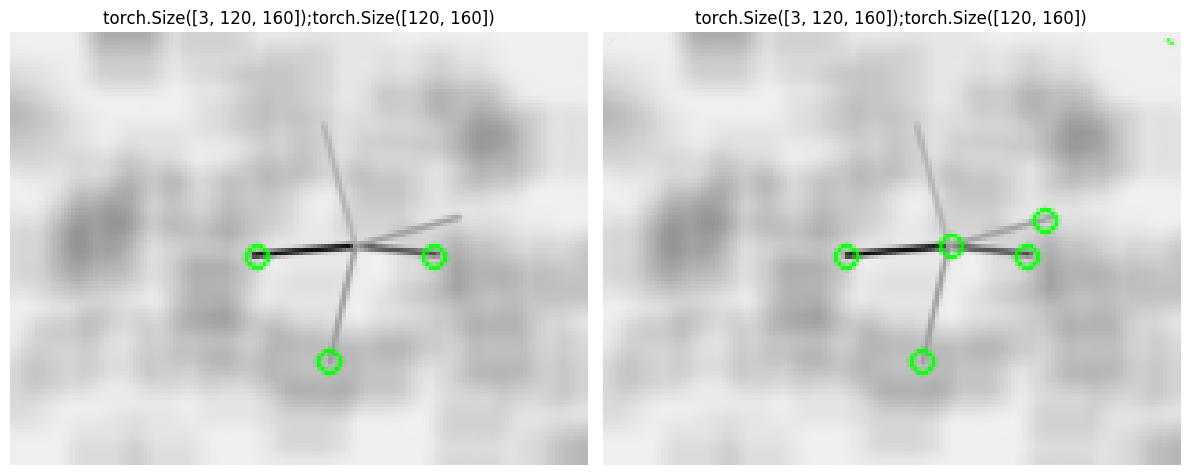

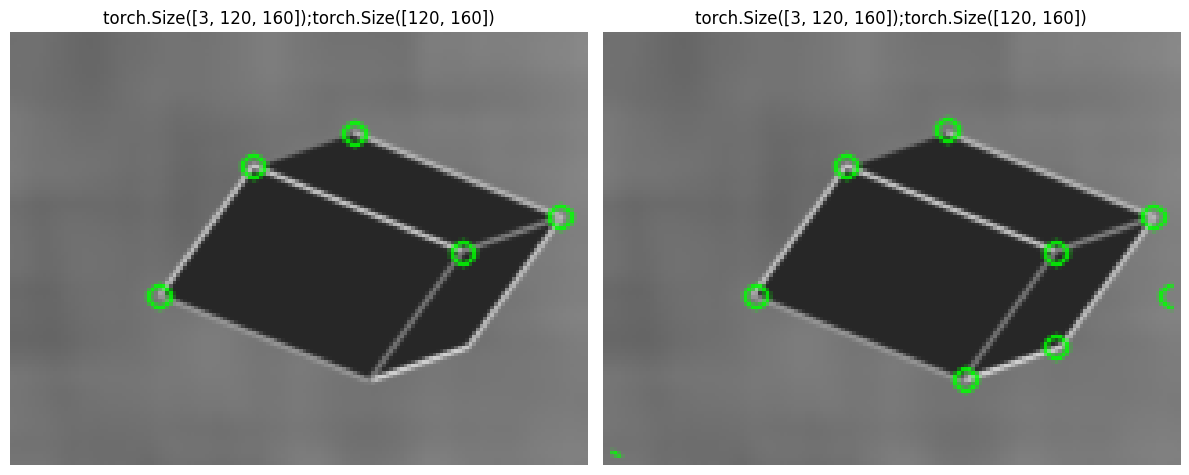

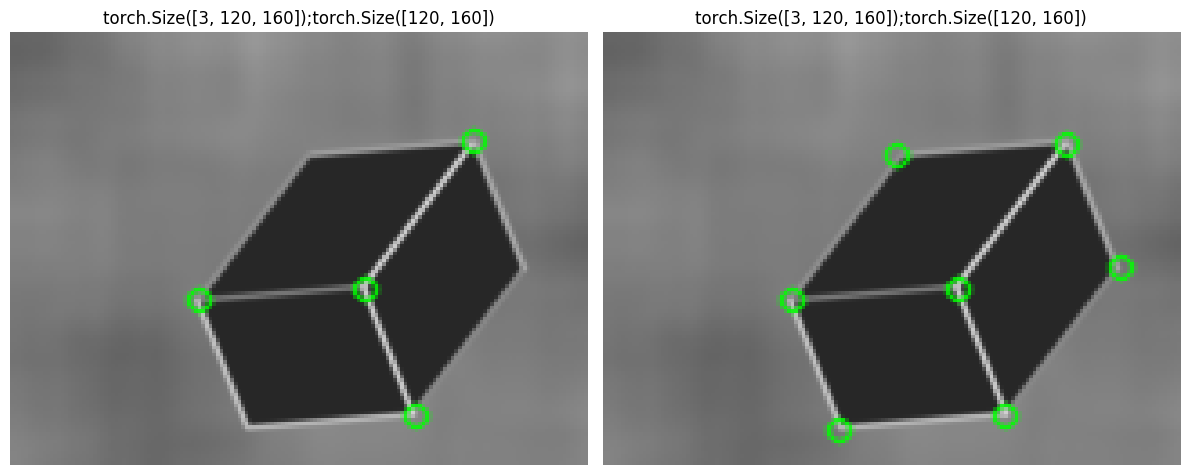

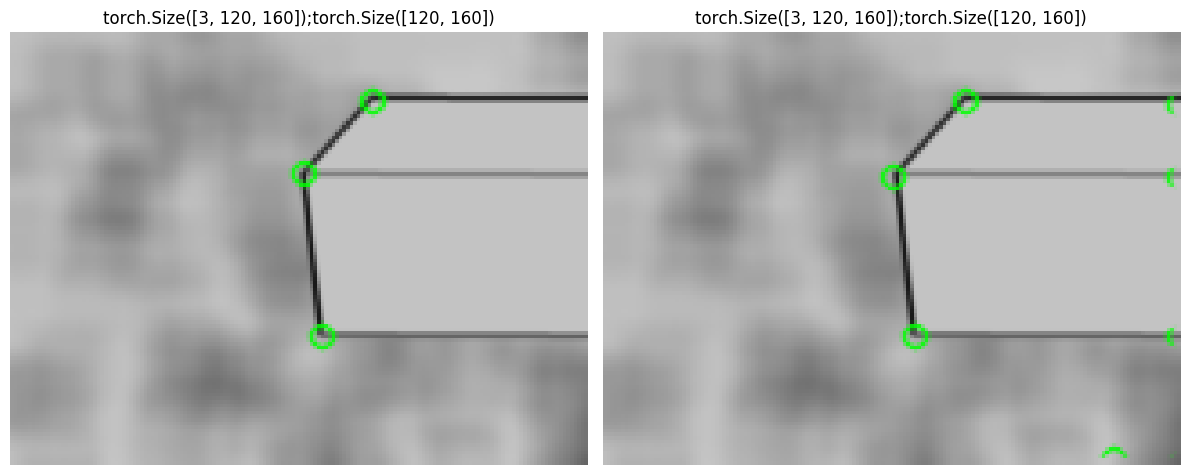

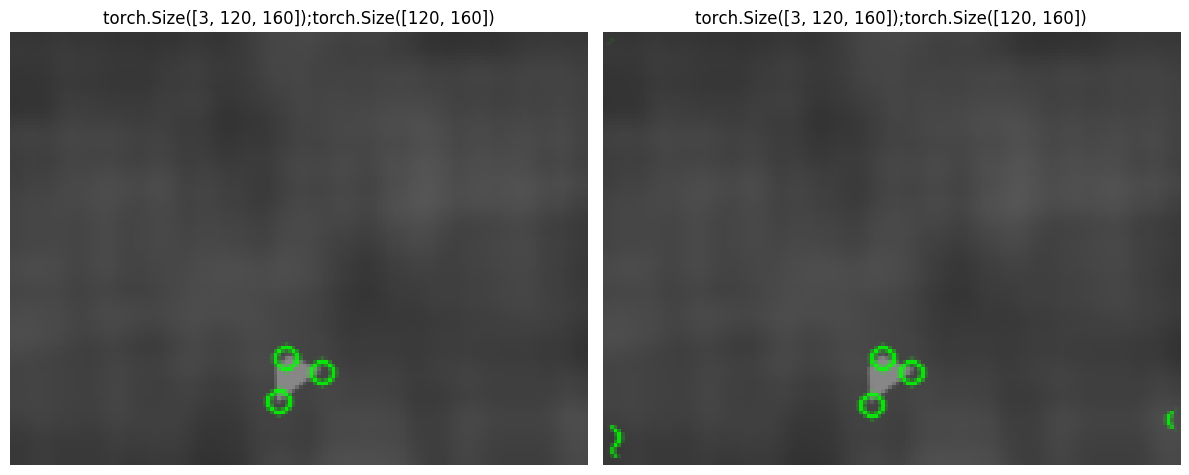

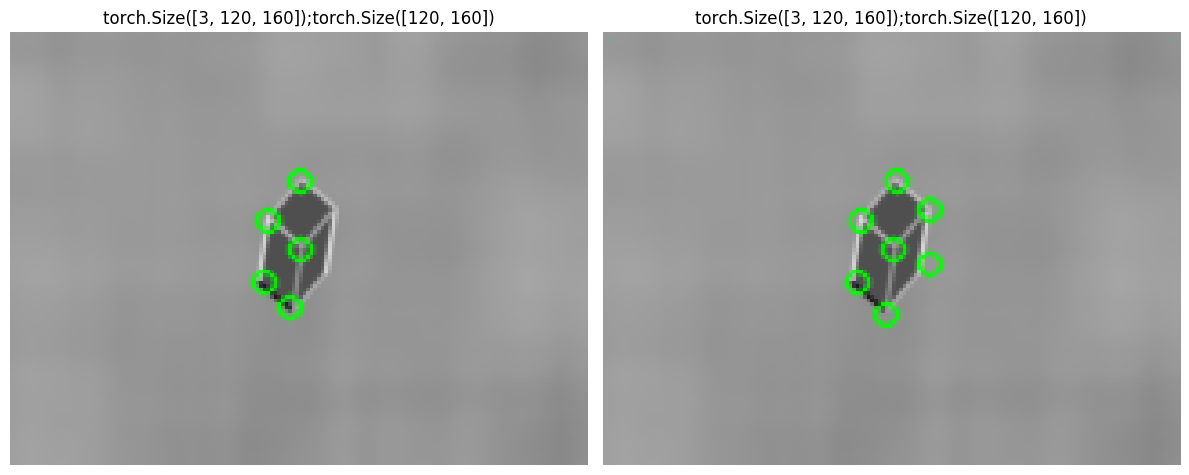

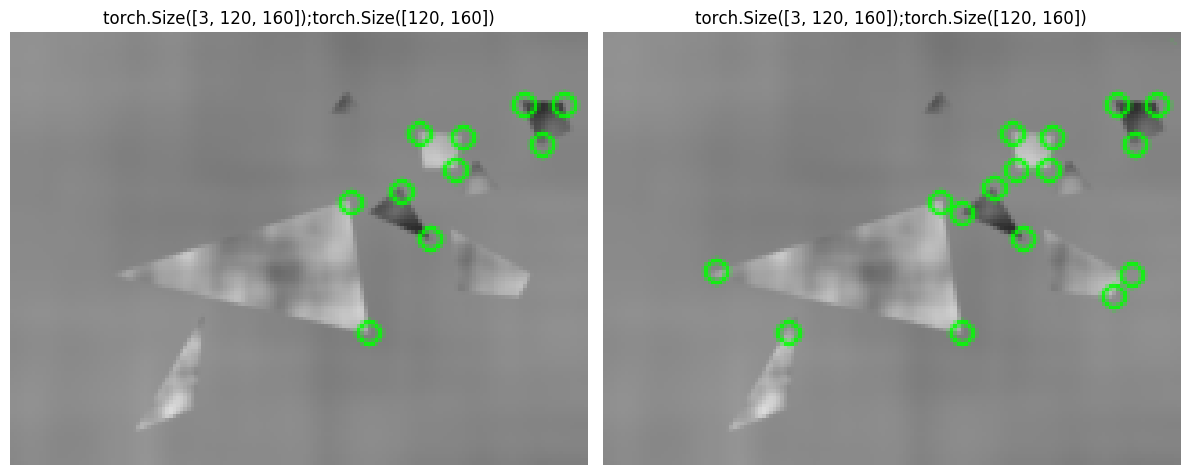

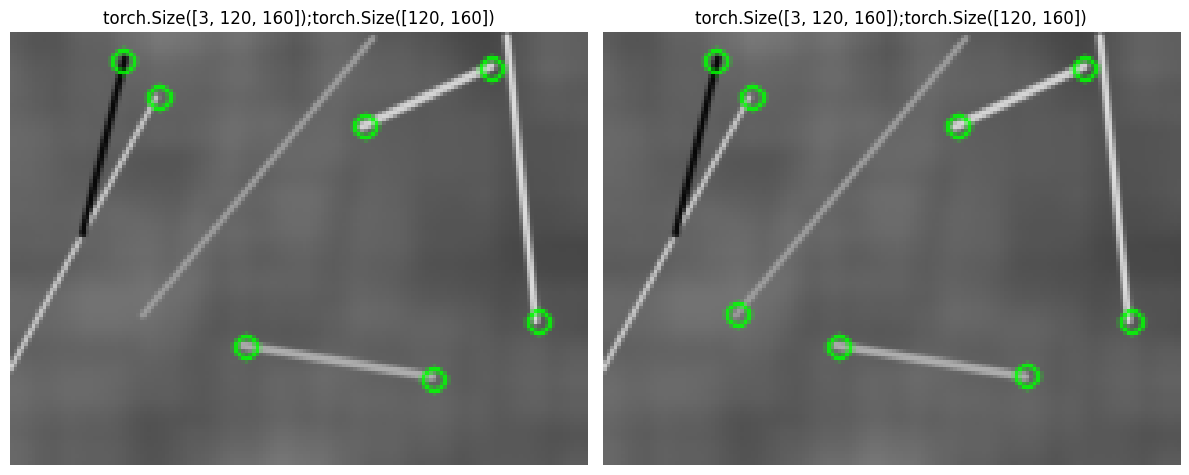

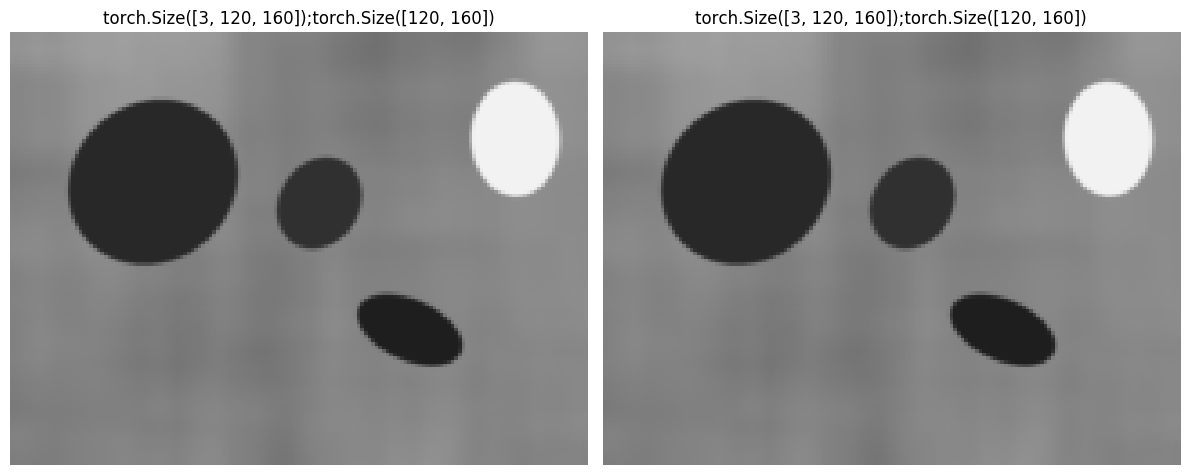

In [108]:
test_dataset(10, art_dataset_loader)